In [1]:
import numpy as np
import hvplot.pandas

import datetime as dt
import panel as pn

pn.extension()
import panel as pn
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta

pn.extension('perspective')

In [2]:
import matplotlib.pyplot as plt


In [3]:
# Contact Project Administrator to get these
TENANT_ID = "3aa4a235-b6e2-48d5-9195-7fcf05b459b0" # AAD using @equinor.com
CLIENT_ID = "3d7a85da-05ab-4675-b5f9-0c4b96a1c84b" # CDF_ALL_USER_APPLICATION_FLOW
CDF_CLUSTER = "westeurope-1"

# -------------for DEV project-----------------
COGNITE_PROJECT = "equinor-dev"

# -------------for TEST project-----------------
# COGNITE_PROJECT = "equinor-test"

In [4]:
from cognite.client import CogniteClient
client = CogniteClient.default_oauth_interactive(
    project=COGNITE_PROJECT,
    tenant_id=TENANT_ID,
    client_id=CLIENT_ID,
    cdf_cluster=CDF_CLUSTER,
    client_name="my-cognite-python-test", # a name to identify your session
)
from cognite.client.data_classes import LabelFilter

In [5]:
display(f'{client.version=} / {client.config.project=}')
# print(client.iam.token.inspect())

"client.version='6.39.6' / client.config.project='equinor-dev'"

In [6]:
wellcom_dataset = "src:015:wellcom"
edm_dataset = "src:012:edm"
witsml_dataset = "src:014:witsmldata"

In [7]:
active_wellbore = "active:wellbore"
match_witsml = "match:witsml:wellcom" # sensor data only for johan svendrup
match_edm = "match:edm:wellcom"

# defien and show datasets

In [8]:
#list wellcom wellbores that are active in WITSML
active_wellbores = client.assets.list(data_set_external_ids = wellcom_dataset, labels=LabelFilter(contains_all=[active_wellbore]), limit=-1)
active_wellbores

,external_id,name,parent_id,parent_external_id,description,data_set_id,metadata,source,labels,id,created_time,last_updated_time,root_id
0,dw:wellcom:WELLBORE:164477857,NO 16/5-K-3 H,7876942777586616,dw:wellcom:WELL:164477851,Wellbore information for: NO 16/5-K-3 H,6346490050989733,"{'EXISTENCE_KD_NM': 'ACTUAL', 'LAST_DR_DATE': ...",src:015:wellcom:rawdb.wellbore,"[{'externalId': 'match:edm:wellcom'}, {'extern...",955508372036290,1694032030374,1715821671591,7876942777586616
1,dw:wellcom:WELLBORE:174967378,NO 16/5-K-2 H,1827766739511413,dw:wellcom:WELL:174967353,Wellbore information for: NO 16/5-K-2 H,6346490050989733,"{'EXISTENCE_KD_NM': 'ACTUAL', 'LAST_DR_DATE': ...",src:015:wellcom:rawdb.wellbore,"[{'externalId': 'match:witsml:wellcom'}, {'ext...",1713830288579674,1694032030530,1715821671591,1827766739511413
2,dw:wellcom:WELLBORE:171031132,NO 16/3-O-3 H,3526246276582693,dw:wellcom:WELL:171030413,Wellbore information for: NO 16/3-O-3 H,6346490050989733,"{'EXISTENCE_KD_NM': 'ACTUAL', 'LAST_DR_DATE': ...",src:015:wellcom:rawdb.wellbore,"[{'externalId': 'match:edm:wellcom'}, {'extern...",2332471204802633,1694032030764,1710723960939,3526246276582693
3,dw:wellcom:WELLBORE:94103429,NO 16/2-D-1,5785855130534576,dw:wellcom:WELL:93930579,Wellbore information for: NO 16/2-D-1,6346490050989733,"{'EXISTENCE_KD_NM': 'ACTUAL', 'LAST_DR_DATE': ...",src:015:wellcom:rawdb.wellbore,"[{'externalId': 'match:edm:wellcom'}, {'extern...",7215111947073855,1694032030858,1710723957890,5785855130534576


In [9]:
witsml_db  = client.time_series.list(data_set_external_ids = witsml_dataset, limit=-1)
witsml_db

,id,external_id,name,is_string,metadata,unit,asset_id,is_step,description,security_categories,data_set_id,created_time,last_updated_time
0,881650803765,dw:witsml:log.49a36410-e7fb-4864-b3c7-c1eba937...,CEMPUMPPR,False,"{'type': 'log', 'commonData_dTimCreation': '20...",Pa,2033175562258369,False,CEMPUMPPR,[],7412963440371515,1699923727680,1715364010763
1,1641460701259,dw:witsml:log.4eccc70b-adba-442b-852c-8f1ab7cb...,MROUT,False,"{'type': 'log', 'commonData_dTimCreation': '20...",ohm.m,8564953405341906,False,MROUT,[],7412963440371515,1699923657815,1715364010763
2,2811296096383,dw:witsml:log.e17da3e3-6e4f-4fdb-a53b-3a433927...,CEMWTIN,False,"{'type': 'log', 'commonData_dTimCreation': '20...",kg/m3,8568419009254753,False,CEMWTIN,[],7412963440371515,1699923671389,1715364010763
3,3562630500496,dw:witsml:log.aa2787e0-bd34-40ba-9783-6426a3d0...,PIT30,False,"{'type': 'log', 'commonData_dTimCreation': '20...",m3,2333496463722180,False,PIT30,[],7412963440371515,1699923753693,1715364010763
4,4349328030238,dw:witsml:log.e5912051-eec4-4b18-9dd5-bc687894...,KILL_PRESS,False,"{'type': 'log', 'commonData_dTimCreation': '20...",Pa,6803620337242231,False,KILL_PRESS,[],7412963440371515,1699923718702,1715364010763
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9478,9003442841042893,dw:witsml:log.e6caf2f9-3e59-4e5d-8b63-b1f495bd...,MWOUT,False,"{'type': 'log', 'commonData_dTimCreation': '20...",kg/m3,4886106907570570,False,MWOUT,[],7412963440371515,1699923682072,1715364012909
9479,9004567224869856,dw:witsml:log.c54bfb78-c126-4982-94b1-6102b1eb...,MUDRETDEPTH,False,"{'type': 'log', 'commonData_dTimCreation': '20...",m,8081963593989476,False,MUDRETDEPTH,[],7412963440371515,1699923743864,1715364012909
9480,9004904195500575,dw:witsml:log.aa2787e0-bd34-40ba-9783-6426a3d0...,CHOKE_PRESS,False,"{'type': 'log', 'commonData_dTimCreation': '20...",Pa,1783617027716013,False,CHOKE_PRESS,[],7412963440371515,1699923739422,1715364012909
9481,9005083314734865,dw:witsml:log.7bd886cb-97e4-4487-92fe-2e1e1f45...,ROP_AVG,False,"{'type': 'log', 'commonData_dTimCreation': '20...",m/s,8725854939492372,False,ROP_AVG,[],7412963440371515,1699923741532,1715364012909


### query directly

## make to padnas

In [10]:
pd_active_wellbores = active_wellbores.to_pandas(metadata_prefix=active_wellbores)
pd_active_wellbores

,external_id,name,parent_id,parent_external_id,description,data_set_id,metadata,source,labels,id,created_time,last_updated_time,root_id
0,dw:wellcom:WELLBORE:164477857,NO 16/5-K-3 H,7876942777586616,dw:wellcom:WELL:164477851,Wellbore information for: NO 16/5-K-3 H,6346490050989733,"{'EXISTENCE_KD_NM': 'ACTUAL', 'LAST_DR_DATE': ...",src:015:wellcom:rawdb.wellbore,"[{'externalId': 'match:edm:wellcom'}, {'extern...",955508372036290,1694032030374,1715821671591,7876942777586616
1,dw:wellcom:WELLBORE:174967378,NO 16/5-K-2 H,1827766739511413,dw:wellcom:WELL:174967353,Wellbore information for: NO 16/5-K-2 H,6346490050989733,"{'EXISTENCE_KD_NM': 'ACTUAL', 'LAST_DR_DATE': ...",src:015:wellcom:rawdb.wellbore,"[{'externalId': 'match:witsml:wellcom'}, {'ext...",1713830288579674,1694032030530,1715821671591,1827766739511413
2,dw:wellcom:WELLBORE:171031132,NO 16/3-O-3 H,3526246276582693,dw:wellcom:WELL:171030413,Wellbore information for: NO 16/3-O-3 H,6346490050989733,"{'EXISTENCE_KD_NM': 'ACTUAL', 'LAST_DR_DATE': ...",src:015:wellcom:rawdb.wellbore,"[{'externalId': 'match:edm:wellcom'}, {'extern...",2332471204802633,1694032030764,1710723960939,3526246276582693
3,dw:wellcom:WELLBORE:94103429,NO 16/2-D-1,5785855130534576,dw:wellcom:WELL:93930579,Wellbore information for: NO 16/2-D-1,6346490050989733,"{'EXISTENCE_KD_NM': 'ACTUAL', 'LAST_DR_DATE': ...",src:015:wellcom:rawdb.wellbore,"[{'externalId': 'match:edm:wellcom'}, {'extern...",7215111947073855,1694032030858,1710723957890,5785855130534576


In [11]:
_pd_witsml = witsml_db.to_pandas(metadata_prefix=witsml_db)
_pd_witsml

,id,external_id,name,is_string,metadata,unit,asset_id,is_step,description,security_categories,data_set_id,created_time,last_updated_time
0,881650803765,dw:witsml:log.49a36410-e7fb-4864-b3c7-c1eba937...,CEMPUMPPR,False,"{'type': 'log', 'commonData_dTimCreation': '20...",Pa,2033175562258369,False,CEMPUMPPR,[],7412963440371515,1699923727680,1715364010763
1,1641460701259,dw:witsml:log.4eccc70b-adba-442b-852c-8f1ab7cb...,MROUT,False,"{'type': 'log', 'commonData_dTimCreation': '20...",ohm.m,8564953405341906,False,MROUT,[],7412963440371515,1699923657815,1715364010763
2,2811296096383,dw:witsml:log.e17da3e3-6e4f-4fdb-a53b-3a433927...,CEMWTIN,False,"{'type': 'log', 'commonData_dTimCreation': '20...",kg/m3,8568419009254753,False,CEMWTIN,[],7412963440371515,1699923671389,1715364010763
3,3562630500496,dw:witsml:log.aa2787e0-bd34-40ba-9783-6426a3d0...,PIT30,False,"{'type': 'log', 'commonData_dTimCreation': '20...",m3,2333496463722180,False,PIT30,[],7412963440371515,1699923753693,1715364010763
4,4349328030238,dw:witsml:log.e5912051-eec4-4b18-9dd5-bc687894...,KILL_PRESS,False,"{'type': 'log', 'commonData_dTimCreation': '20...",Pa,6803620337242231,False,KILL_PRESS,[],7412963440371515,1699923718702,1715364010763
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9478,9003442841042893,dw:witsml:log.e6caf2f9-3e59-4e5d-8b63-b1f495bd...,MWOUT,False,"{'type': 'log', 'commonData_dTimCreation': '20...",kg/m3,4886106907570570,False,MWOUT,[],7412963440371515,1699923682072,1715364012909
9479,9004567224869856,dw:witsml:log.c54bfb78-c126-4982-94b1-6102b1eb...,MUDRETDEPTH,False,"{'type': 'log', 'commonData_dTimCreation': '20...",m,8081963593989476,False,MUDRETDEPTH,[],7412963440371515,1699923743864,1715364012909
9480,9004904195500575,dw:witsml:log.aa2787e0-bd34-40ba-9783-6426a3d0...,CHOKE_PRESS,False,"{'type': 'log', 'commonData_dTimCreation': '20...",Pa,1783617027716013,False,CHOKE_PRESS,[],7412963440371515,1699923739422,1715364012909
9481,9005083314734865,dw:witsml:log.7bd886cb-97e4-4487-92fe-2e1e1f45...,ROP_AVG,False,"{'type': 'log', 'commonData_dTimCreation': '20...",m/s,8725854939492372,False,ROP_AVG,[],7412963440371515,1699923741532,1715364012909


### query pandas

In [12]:
_pd_witsml.columns

Index(['id', 'external_id', 'name', 'is_string', 'metadata', 'unit',
       'asset_id', 'is_step', 'description', 'security_categories',
       'data_set_id', 'created_time', 'last_updated_time'],
      dtype='object')

In [13]:
import json 
import pandas as pd 
# from pandas.json_normalize import json_normalize #package for flattening json in pandas df

In [14]:
df = pd.concat([_pd_witsml.drop(['metadata'], axis=1), pd.json_normalize(_pd_witsml['metadata'])], axis=1)



In [15]:
df.columns

Index(['id', 'external_id', 'name', 'is_string', 'unit', 'asset_id', 'is_step',
       'description', 'security_categories', 'data_set_id', 'created_time',
       'last_updated_time', 'type', 'commonData_dTimCreation',
       'commonData_dTimLastChange', 'commonData_itemState',
       'commonData_sourceName', 'creationDate', 'direction',
       'endDateTimeIndex', 'indexCurve', 'indexType', 'name', 'nameWell',
       'nameWellbore', 'nullValue', 'objectGrowing', 'serviceCompany',
       'startDateTimeIndex', 'uidWell', 'uidWellbore', 'uidLog',
       'unavailable_in_source', 'witsml-server-ref', 'source',
       'curveDescription', 'maxDateTimeIndex', 'minDateTimeIndex', 'mnemAlias',
       'mnemonic', 'typeLogData', 'uid', 'unit'],
      dtype='object')

In [16]:
_df_selcected_col = df[['id', 'uidWell', 'uidWellbore',  'nameWellbore','external_id', 'name', 'is_string', 'unit', 'asset_id', 'is_step',
       'description', 'security_categories', 'data_set_id', 'created_time',
       'last_updated_time', 'type', 'commonData_dTimCreation',
       'commonData_dTimLastChange', 'commonData_itemState',
       'commonData_sourceName', 'creationDate', 'direction',
       'endDateTimeIndex', 'indexCurve', 'indexType', 'name', 'nameWell',
       'nullValue', 'objectGrowing', 'serviceCompany',
       'startDateTimeIndex',  'uidLog',
       'unavailable_in_source', 'witsml-server-ref', 'source',
       'curveDescription', 'maxDateTimeIndex', 'minDateTimeIndex', 'mnemAlias',
       'mnemonic', 'typeLogData', 'uid', 'unit']]
_df_selcected_col

,id,uidWell,uidWellbore,nameWellbore,external_id,name,name,is_string,unit,unit,...,source,curveDescription,maxDateTimeIndex,minDateTimeIndex,mnemAlias,mnemonic,typeLogData,uid,unit,unit
0,881650803765,49a36410-e7fb-4864-b3c7-c1eba937dcd9,0ac9cfa3-b6a0-4af3-85e4-3180f68f0c11,NO 16/2-D-2 T4,dw:witsml:log.49a36410-e7fb-4864-b3c7-c1eba937...,CEMPUMPPR,Surface Logging Data - Time RT,False,Pa,Pa,...,KongsbergDigital,Cementing Pump Pressure,2023-01-11T17:29:47.000000Z,2022-11-24T05:27:00.000000Z,CEMPUMPPR,CEMPUMPPR,double,CEMPUMPPR,Pa,Pa
1,1641460701259,4eccc70b-adba-442b-852c-8f1ab7cbcf77,b467d241-4086-47c5-9c6a-a6fc8cd010ce,NO 16/2-D-10,dw:witsml:log.4eccc70b-adba-442b-852c-8f1ab7cb...,MROUT,Surface Logging Data - Time RT,False,ohm.m,ohm.m,...,KongsbergDigital,Mud Resistivity Out,2019-08-22T08:40:57.000000Z,2019-08-22T03:56:45.000000Z,MROUT,MROUT,double,MROUT,ohm.m,ohm.m
2,2811296096383,e17da3e3-6e4f-4fdb-a53b-3a43392721ef,dc0ea5a6-c45c-4e1b-a57b-cde2bdd3af2c,NO 16/2-D-42,dw:witsml:log.e17da3e3-6e4f-4fdb-a53b-3a433927...,CEMWTIN,Surface Logging Data - Time RT,False,kg/m3,kg/m3,...,KongsbergDigital,Cementing Fluid Density In,2021-04-30T18:29:10.000000Z,2020-06-04T08:59:00.000000Z,CEMWTIN,CEMWTIN,double,CEMWTIN,kg/m3,kg/m3
3,3562630500496,aa2787e0-bd34-40ba-9783-6426a3d0f952,542e790e-9b76-40a6-ab97-3b75e1ebfa8c,NO 16/2-H-3 AH,dw:witsml:log.aa2787e0-bd34-40ba-9783-6426a3d0...,PIT30,Surface Logging Data - Time RT,False,m3,m3,...,KongsbergDigital,Pit 30 Volume,2023-07-28T20:23:30.000000Z,2023-07-09T20:56:30.000000Z,PIT30,PIT30,double,PIT30,m3,m3
4,4349328030238,e5912051-eec4-4b18-9dd5-bc687894a406,b2598fc0-bcce-4120-a51c-5006ff331fad,NO 16/2-D-37,dw:witsml:log.e5912051-eec4-4b18-9dd5-bc687894...,KILL_PRESS,Surface Logging Data - Time RT,False,Pa,Pa,...,KongsbergDigital,Kill Pressure,2022-10-12T08:05:02.000000Z,2022-02-06T01:26:18.000000Z,KILL_PRESS,KILL_PRESS,double,KILL_PRESS,Pa,Pa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9478,9003442841042893,e6caf2f9-3e59-4e5d-8b63-b1f495bd4cab,76a03464-fc18-4fac-9e36-64d683334a78,NO 16/2-D-17 T2,dw:witsml:log.e6caf2f9-3e59-4e5d-8b63-b1f495bd...,MWOUT,Surface Logging Data - Time RT,False,kg/m3,kg/m3,...,KongsbergDigital,Mud Weight Out,2021-03-06T23:31:28.000000Z,2021-02-12T16:46:14.000000Z,MWOUT,MWOUT,double,MWOUT,kg/m3,kg/m3
9479,9004567224869856,c54bfb78-c126-4982-94b1-6102b1ebfbc4,ae0d9b30-14d1-4b4c-b259-1924f241e304,NO 16/3-Q-4 H,dw:witsml:log.c54bfb78-c126-4982-94b1-6102b1eb...,MUDRETDEPTH,Surface Logging Data - Time RT,False,m,m,...,KongsbergDigital,Lagged Mud Returns Depth,2023-12-01T20:00:00.000000Z,2023-06-20T22:31:00.000000Z,MUDRETDEPTH,MUDRETDEPTH,double,MUDRETDEPTH,m,m
9480,9004904195500575,aa2787e0-bd34-40ba-9783-6426a3d0f952,96d15724-b9f8-4d38-a392-5b585cb9900a,NO 16/2-H-3 H,dw:witsml:log.aa2787e0-bd34-40ba-9783-6426a3d0...,CHOKE_PRESS,Surface Logging Data - Time RT,False,Pa,Pa,...,KongsbergDigital,Choke Pressure,2023-07-09T20:43:59.000000Z,2023-06-11T18:32:42.000000Z,CHOKE_PRESS,CHOKE_PRESS,double,CHOKE_PRESS,Pa,Pa
9481,9005083314734865,7bd886cb-97e4-4487-92fe-2e1e1f4515a7,7ce59fac-8b44-4176-8c4d-60f09dc89de3,NO 16/3-Q-2 H,dw:witsml:log.7bd886cb-97e4-4487-92fe-2e1e1f45...,ROP_AVG,Surface Logging Data - Time RT,False,m/s,m/s,...,KongsbergDigital,Time Averaged ROP,2023-06-20T17:39:47.000000Z,2023-06-17T12:28:52.000000Z,ROP_AVG,ROP_AVG,double,ROP_AVG,m/s,m/s


In [17]:
_df_selcected_col[_df_selcected_col['description'] == 'BITDEP']['external_id'].iloc[0]

'dw:witsml:log.90485438-0aba-42a5-bc78-75e3a21bcf72.5a8d0cff-5299-4bde-bc4f-1fcffa81be50.5a8d0cff-5299-4bde-bc4f-1fcffa81be50.bitdep||v1'

In [18]:
_df_selcected_col['nameWell'].nunique()

56

In [19]:
_df_name_is_cempumppr = _df_selcected_col[_df_selcected_col['description'] == 'CEMPUMPPR']

In [20]:
_df_name_is_cempumppr.sort_values(by=['startDateTimeIndex']).head(80)

,id,uidWell,uidWellbore,nameWellbore,external_id,name,name,is_string,unit,unit,...,source,curveDescription,maxDateTimeIndex,minDateTimeIndex,mnemAlias,mnemonic,typeLogData,uid,unit,unit
6797,6412144277762574,c54bfb78-c126-4982-94b1-6102b1ebfbc4,ae0d9b30-14d1-4b4c-b259-1924f241e304,NO 16/3-Q-4 H,dw:witsml:log.c54bfb78-c126-4982-94b1-6102b1eb...,CEMPUMPPR,Surface Logging Data - Time RT,False,Pa,Pa,...,KongsbergDigital,Cementing Pump Pressure,2023-06-20T22:46:20.000000Z,1900-01-01T00:00:00.000000Z,CEMPUMPPR,CEMPUMPPR,double,CEMPUMPPR,Pa,Pa
9089,8616102998055654,0cf8f65b-cc3a-4608-bfcd-615214a2ee4a,96ab3a86-5e15-442f-ba3a-e9ae7a494ea2,NO 16/2-D-18,dw:witsml:log.0cf8f65b-cc3a-4608-bfcd-615214a2...,CEMPUMPPR,Surface Logging Data - Time RT,False,Pa,Pa,...,KongsbergDigital,Cementing Pump Pressure,2020-02-21T17:02:00.000000Z,2019-12-22T19:46:40.000000Z,CEMPUMPPR,CEMPUMPPR,double,CEMPUMPPR,Pa,Pa
2175,2008009588366199,f5994408-36e6-4143-8b83-d04def72f951,14ad7b6b-4b96-4581-a1c5-4490b0a5c935,NO 16/2-D-14,dw:witsml:log.f5994408-36e6-4143-8b83-d04def72...,CEMPUMPPR,Surface Logging Data - Time RT,False,Pa,Pa,...,KongsbergDigital,Cementing Pump Pressure,2019-06-07T07:44:30.000000Z,2019-05-29T08:54:00.000000Z,CEMPUMPPR,CEMPUMPPR,double,CEMPUMPPR,Pa,Pa
5269,5007980212020715,8ae2ee08-9235-4e02-9818-15b223232380,ab67aae3-4235-4bca-acea-3079c48824b5,NO 16/2-D-12,dw:witsml:log.8ae2ee08-9235-4e02-9818-15b22323...,CEMPUMPPR,Surface Logging Data - Time RT,False,Pa,Pa,...,KongsbergDigital,Cementing Pump Pressure,2019-10-08T08:19:30.000000Z,2019-06-07T09:25:00.000000Z,CEMPUMPPR,CEMPUMPPR,double,CEMPUMPPR,Pa,Pa
3018,2813543266430008,e6caf2f9-3e59-4e5d-8b63-b1f495bd4cab,8b1fbf9e-c8aa-4e35-9c3c-8bab417e43fa,NO 16/2-D-17,dw:witsml:log.e6caf2f9-3e59-4e5d-8b63-b1f495bd...,CEMPUMPPR,Surface Logging Data - Time RT,False,Pa,Pa,...,KongsbergDigital,Cementing Pump Pressure,2021-02-12T15:31:40.000000Z,2021-01-26T06:55:10.000000Z,CEMPUMPPR,CEMPUMPPR,double,CEMPUMPPR,Pa,Pa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2747,2562056459241702,11a065ca-4325-4da0-ab9b-07a288dd97e1,c9587688-bfe5-4289-b221-e9270b1ddd0d,NO 16/2-D-48,dw:witsml:log.11a065ca-4325-4da0-ab9b-07a288dd...,CEMPUMPPR,Surface Logging Data - Time RT,False,Pa,Pa,...,KongsbergDigital,Cementing Pump Pressure,2024-02-13T22:49:10.000000Z,2024-02-09T18:14:11.000000Z,CEMPUMPPR,CEMPUMPPR,double,CEMPUMPPR,Pa,Pa
1548,1439318167596414,95992c20-f691-40d9-86e1-4f3e5ce823b4,51c884c6-bafa-47c2-9bf2-e7785a2d2c01,NO 16/2-D-35 T2,dw:witsml:log.95992c20-f691-40d9-86e1-4f3e5ce8...,CEMPUMPPR,Surface Logging Data - Time RT,False,Pa,Pa,...,KongsbergDigital,Cementing Pump Pressure,2024-03-25T11:59:50.000000Z,2024-02-18T05:23:42.000000Z,CEMPUMPPR,CEMPUMPPR,double,CEMPUMPPR,Pa,Pa
5027,4759913348357306,b198ca8c-58f2-490b-91cf-797ac6079d28,ef3d755c-c00f-43ec-8e6a-4d6b9438168f,NO 16/3-O-1 HT2,dw:witsml:log.b198ca8c-58f2-490b-91cf-797ac607...,CEMPUMPPR,Surface Logging Data - Time RT,False,Pa,Pa,...,KongsbergDigital,Cementing Pump Pressure,2024-04-25T09:16:58.000000Z,2024-03-31T23:17:00.000000Z,CEMPUMPPR,CEMPUMPPR,double,CEMPUMPPR,Pa,Pa
1493,1385525806544474,2f1add5d-dc06-4be1-94db-211670a07c84,01f5a477-a501-4e43-b80d-17f034b5f254,NO 16/2-D-44 T2,dw:witsml:log.2f1add5d-dc06-4be1-94db-211670a0...,CEMPUMPPR,Surface Logging Data - Time RT,False,Pa,Pa,...,KongsbergDigital,Cementing Pump Pressure,2024-06-10T14:10:50.000000Z,2024-05-10T16:52:30.000000Z,CEMPUMPPR,CEMPUMPPR,double,CEMPUMPPR,Pa,Pa


In [21]:
len(_df_name_is_cempumppr)

78

In [22]:
len(_df_name_is_cempumppr['nameWellbore'].unique())

74

## get for bitdept

In [23]:
_df_name_is_bitdep = _df_selcected_col[_df_selcected_col['description'] == 'BITDEP']

In [24]:
_df_name_is_bitdep[_df_name_is_bitdep['nameWellbore'] == 'NO 16/2-D-15']

,id,uidWell,uidWellbore,nameWellbore,external_id,name,name,is_string,unit,unit,...,source,curveDescription,maxDateTimeIndex,minDateTimeIndex,mnemAlias,mnemonic,typeLogData,uid,unit,unit
8169,7754896165576453,1ac57fe7-4c90-4bc7-a350-8d17f077bb32,05424d07-6a7d-4ef2-acc1-2c2a6c2eb062,NO 16/2-D-15,dw:witsml:log.1ac57fe7-4c90-4bc7-a350-8d17f077...,BITDEP,Surface Logging Data - Time RT,False,m,m,...,KongsbergDigital,The mnemonic of the Hole depth,2019-12-02T19:03:38.000000Z,2019-09-08T04:35:28.000000Z,BITDEP,BITDEP,double,BITDEP,m,m


## set sensorid

In [25]:
_sel_sensorid = int(_df_name_is_bitdep[_df_name_is_bitdep['nameWellbore'] == 'NO 16/2-D-15'].id.iloc[0])
_sel_sensorid 

7754896165576453

#### make list of all sensorids to use in panel

In [26]:
_sensorids_list = pd.Series(_df_name_is_bitdep['name']).unique().tolist()
# _sensorids_list

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [34]:
sr2 = pd.Series(pd.Series(_df_name_is_bitdep['nameWellbore']).tolist(), index = _df_name_is_bitdep['id'])
d = {key: value for key, value in sr2.items()}
_sensorids_list = d
_sensorids_list


{114925988185573: 'NO 16/3-O-2 HT2',
 540388646753556: 'NO 16/2-D-44',
 553303436762434: 'NO 16/2-D-42 T2',
 610889273075352: 'NO 16/2-H-3 H',
 746172675242144: 'NO 16/2-D-43',
 807541165501966: 'NO 16/3-P-4 H',
 864186469645318: 'NO 16/3-Q-1 H',
 885149193008514: 'NO 16/2-D-7',
 908832947568610: 'NO 16/2-D-4',
 956495648801814: 'NO 16/3-Q-4 HT2',
 1138197140994517: 'NO 16/2-D-42',
 1415941041496504: 'NO 16/2-D-40',
 1570677098860114: 'NO 16/2-D-37',
 1743715413643747: 'NO 16/3-O-4 H',
 1820004034410290: 'NO 16/3-O-1 HT2',
 1822774244156829: 'NO 16/3-Q-4 H',
 1934667450362902: 'NO 16/3-O-2 HT3',
 2086215955982590: 'NO 16/2-D-1',
 2181584989341830: 'NO 16/2-D-2 T2',
 2220634486483244: 'NO 16/2-D-10',
 2337663974754072: 'NO 16/2-D-39',
 2452199672533487: 'NO 16/2-D-21',
 2759820873419026: 'NO 16/2-D-41',
 2832860854551760: 'NO 16/2-D-38',
 2837910117511181: 'NO 16/2-D-16 T2',
 2896995270371612: 'NO 16/2-H-1 H',
 2911505954954534: 'NO 16/5-K-2 H',
 3088543739857874: 'NO 16/2-D-17 T2',
 31

#### panel choose _sel_sensorid

In [ ]:
indicator = pn.indicators.LoadingSpinner(value=False, size=25)
text = pn.widgets.TextInput(value='Start')

def update_indicator(event, clicks):
    if not event:
        return
    
    indicator.value = not indicator.value
    text.value = f"you have clicked me {clicks} times"

pn.bind(update_indicator, test_widget, test_widget.param.clicks, watch=True)

pn.Column(pn.Row(test_widget, text),indicator)

NameError: name 'test_widget' is not defined

In [28]:
import param

In [ ]:
%pip install panel

^C
Note: you may need to restart the kernel to use updated packages.


In [33]:
# _sensorids_list = [{1:"fefe"}, {2 :"foo"}]

In [35]:
_sel_sensorid_widget = pn.widgets.Select(name='Select', options=_sensorids_list)



# def _update__sel_sensorid
# @param.depends(_sel_sensorid_widget.param.values().__getattribute__('value'))
def _update__sel_sensorid( self, value):
    _sel_sensorid = value
    return _sel_sensorid

# bind _sel_sensorid to event _sel_sensorid_widget and display together with _sel_sensorid_widget
pn.Row(_sel_sensorid_widget, _sel_sensorid_widget.param.values().__getitem__('value'), pn.bind(_update__sel_sensorid, _sel_sensorid_widget,value=_sel_sensorid_widget.param.values().__getitem__('value'), watch=True )).servable() 

# pn.Row(_sel_sensorid_widget, pn.bind(_update__sel_sensorid, _sel_sensorid_widget,value=_sel_sensorid_widget.param.values().items())).servable()

BokehModel(combine_events=True, render_bundle={'docs_json': {'8c322e07-6b8a-45e7-972f-11bf096ab32f': {'version…

In [38]:
_sel_sensorid =_sel_sensorid_widget.param.values().__getitem__('value')
_sel_sensorid
## TODO why is _sel_sensorid not updating automatically?

'NO 16/2-D-1'

In [32]:
_sel_sensorid

{2: 'foo'}

In [ ]:
_sel_sensorid = 746172675242144

## TIME SERIES QUERY based on _sel_sensorid

In [ ]:
from cognite.client.utils import MIN_TIMESTAMP_MS, MAX_TIMESTAMP_MS

In [ ]:
client.time_series.data.retrieve(id=746172675242144,
    start=MIN_TIMESTAMP_MS,
    end=MAX_TIMESTAMP_MS + 1)

CogniteConnectionError: 

In [ ]:
dps_backup = client.time_series.data.retrieve(
    id=_sel_sensorid,
    start=MIN_TIMESTAMP_MS,
    end=MAX_TIMESTAMP_MS + 1) 
dps_backup


,dw:witsml:log.1ac57fe7-4c90-4bc7-a350-8d17f077bb32.05424d07-6a7d-4ef2-acc1-2c2a6c2eb062.05424d07-6a7d-4ef2-acc1-2c2a6c2eb062.bitdep||v1
2019-09-08 04:35:28,0.000000
2019-09-08 04:35:29,0.000000
2019-09-08 04:35:30,0.000000
2019-09-08 04:35:33,0.000000
2019-09-08 04:35:36,0.000000
...,...
2019-12-02 19:03:27,3553.760000
2019-12-02 19:03:30,3553.763999
2019-12-02 19:03:33,3553.760000
2019-12-02 19:03:36,3553.760000


## to pandas

In [ ]:
_pd_dps_backup = dps_backup.to_pandas( )
# make Value columsn or easier filtering
_pd_dps_backup['Value'] = _pd_dps_backup[_pd_dps_backup.columns]

In [ ]:
_pd_dps_backup.sort_index(ascending=False)

,dw:witsml:log.1ac57fe7-4c90-4bc7-a350-8d17f077bb32.05424d07-6a7d-4ef2-acc1-2c2a6c2eb062.05424d07-6a7d-4ef2-acc1-2c2a6c2eb062.bitdep||v1,Value
2019-12-02 19:03:38,3553.760000,3553.760000
2019-12-02 19:03:36,3553.760000,3553.760000
2019-12-02 19:03:33,3553.760000,3553.760000
2019-12-02 19:03:30,3553.763999,3553.763999
2019-12-02 19:03:27,3553.760000,3553.760000
...,...,...
2019-09-08 04:35:36,0.000000,0.000000
2019-09-08 04:35:33,0.000000,0.000000
2019-09-08 04:35:30,0.000000,0.000000
2019-09-08 04:35:29,0.000000,0.000000


## Panel

In [ ]:
indicator = pn.indicators.LoadingSpinner(value=False, size=25)
text = pn.widgets.TextInput(value='Start')

def update_indicator(event, clicks):
    if not event:
        return
    
    indicator.value = not indicator.value
    text.value = f"you have clicked me {clicks} times"

pn.bind(update_indicator, test_widget, test_widget.param.clicks, watch=True)

pn.Column(pn.Row(test_widget, text),indicator)

In [ ]:
df_widget = pn.widgets.DataFrame(_pd_dps_backup, name='DataFrame')

df_widget

BokehModel(combine_events=True, render_bundle={'docs_json': {'123ba132-7479-46ae-b22f-3c23b8d2e2f7': {'version…

In [ ]:
%pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import numpy as np
import plotly.graph_objs as go

import panel as pn

pn.extension("plotly")

xx = np.linspace(-3.5, 3.5, 100)
yy = np.linspace(-3.5, 3.5, 100)
x, y = np.meshgrid(xx, yy)
z = np.exp(-((x - 1) ** 2) - y**2) - (x**3 + y**4 - x / 5) * np.exp(-(x**2 + y**2))

surface=go.Surface(z=z)
fig = go.Figure(data=[surface])

fig.update_layout(
    title="Plotly 3D Plot",
    width=500,
    height=500,
    margin=dict(t=50, b=50, r=50, l=50),
)

plotly_pane = pn.pane.Plotly(fig)
plotly_pane

BokehModel(combine_events=True, render_bundle={'docs_json': {'1649bdaa-9d0a-49f9-a9d4-65687393a36b': {'version…

In [ ]:

stream_perspective = pn.pane.Perspective(
    _pd_dps_backup, plugin='d3_y_line', columns=['Value'], 
    sizing_mode='stretch_width', height=500, margin=0
)

stream_perspective

NameError: name '_pd_dps_backup' is not defined

In [ ]:
test= pn.Row(stream_perspective.controls(), stream_perspective, height=800)


In [ ]:
pn.pane.Perspective(
    _pd_dps_backup,columns=['Value']
).servable()

BokehModel(combine_events=True, render_bundle={'docs_json': {'918d9210-f5a7-4a65-9dc9-4353e078ab2f': {'version…

In [ ]:
import panel as pn
import numpy as np

from matplotlib.figure import Figure

pn.extension(sizing_mode="stretch_width", template="bootstrap")

data = _pd_dps_backup
fig = Figure(figsize=(8,4))
ax = fig.subplots()
ax.hist(data, bins=20)

pn.pane.Matplotlib(fig, format='svg', sizing_mode='scale_both').servable()

BokehModel(combine_events=True, render_bundle={'docs_json': {'ad68c9da-a0f6-447f-aebb-69eac77eb350': {'version…

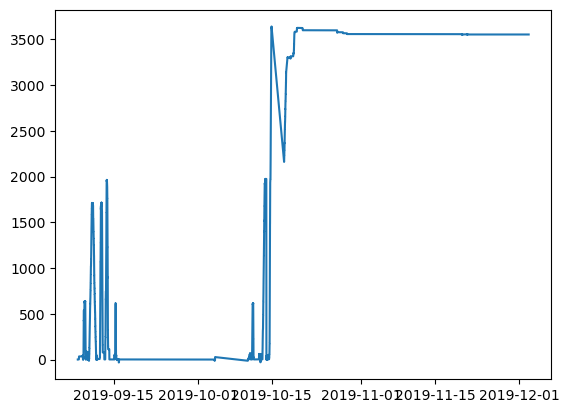

In [ ]:
plt.plot(_pd_dps_backup.index, _pd_dps_backup['Value'])
plt.show()

In [ ]:
_pd_dps_backup.head(5)

,dw:witsml:log.1ac57fe7-4c90-4bc7-a350-8d17f077bb32.05424d07-6a7d-4ef2-acc1-2c2a6c2eb062.05424d07-6a7d-4ef2-acc1-2c2a6c2eb062.bitdep||v1,Value
2019-09-08 04:35:28,0.0,0.0
2019-09-08 04:35:29,0.0,0.0
2019-09-08 04:35:30,0.0,0.0
2019-09-08 04:35:33,0.0,0.0
2019-09-08 04:35:36,0.0,0.0


## panel

In [ ]:
select = pn.widgets.Select(name='Select', options=_pd_dps_backup)

select

ValueError: ClassSelector parameter 'SelectBase.options' value must be an instance of (dict, list), not                      dw:witsml:log.1ac57fe7-4c90-4bc7-a350-8d17f077bb32.05424d07-6a7d-4ef2-acc1-2c2a6c2eb062.05424d07-6a7d-4ef2-acc1-2c2a6c2eb062.bitdep||v1  \
2019-09-08 04:35:28                                           0.000000                                                                                         
2019-09-08 04:35:29                                           0.000000                                                                                         
2019-09-08 04:35:30                                           0.000000                                                                                         
2019-09-08 04:35:33                                           0.000000                                                                                         
2019-09-08 04:35:36                                           0.000000                                                                                         
...                                                                ...                                                                                         
2019-12-02 19:03:27                                        3553.760000                                                                                         
2019-12-02 19:03:30                                        3553.763999                                                                                         
2019-12-02 19:03:33                                        3553.760000                                                                                         
2019-12-02 19:03:36                                        3553.760000                                                                                         
2019-12-02 19:03:38                                        3553.760000                                                                                         

                           Value  
2019-09-08 04:35:28     0.000000  
2019-09-08 04:35:29     0.000000  
2019-09-08 04:35:30     0.000000  
2019-09-08 04:35:33     0.000000  
2019-09-08 04:35:36     0.000000  
...                          ...  
2019-12-02 19:03:27  3553.760000  
2019-12-02 19:03:30  3553.763999  
2019-12-02 19:03:33  3553.760000  
2019-12-02 19:03:36  3553.760000  
2019-12-02 19:03:38  3553.760000  

[2254116 rows x 2 columns].